# Entropy Computation by Clusters for Oldbie and Newbie

## 1. Prepare Data

### 1-1. Questions for nb and ob

In [14]:
import pickle
import pandas as pd
import numpy as np
import sqlite3
import os
import matplotlib.pyplot as plt

# PreComputed Clusters (from cluster_ent.ipynb)
with open(file = '/data1/StackOverflow/_Robustness/TagCluster/post_cluster_pre.pickle', mode = 'rb') as file:
    data = pickle.load(file)

# Import Questions dataset to add owner_user_id feature to pre-computed cluster data.
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date, owner_user_id, tags
FROM questions
WHERE creation_date > '2021-09-01'
AND creation_date < '2023-09-01';
'''
df = pd.read_sql_query(query, conn)
conn.close()

# Import Users Data
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date
FROM users;
'''
user_df = pd.read_sql_query(query, conn)
conn.close()

In [15]:
user_df = user_df.rename(columns = {'creation_date':'account_creation_date',
                                    'id': 'owner_user_id'})
df = df.dropna(subset=['owner_user_id'])
df['owner_user_id'] = df['owner_user_id'].astype(int).astype(str)
user_df['owner_user_id'] = user_df.owner_user_id.astype(str)
df_merge = pd.merge(df, user_df, on = 'owner_user_id', how = 'left')
# erase outliers
# Compute difference between post creation_date - user creation_date.
df_merge['month_diff'] = (pd.to_datetime(df_merge['creation_date']) - pd.to_datetime(df_merge['account_creation_date'])) / pd.Timedelta(days=30)
# There are some negative values in the raw data.
df_merge = df_merge[df_merge['month_diff'] >= 0]
df_merge['year_month'] = pd.to_datetime(df_merge['creation_date']).dt.to_period('M') # Monthly
df_merge['account_year_month'] = pd.to_datetime(df_merge['account_creation_date']).dt.to_period('M') # Monthly
df_merge

,id,creation_date,owner_user_id,tags,account_creation_date,month_diff,year_month,account_year_month
0,69006423,2021-09-01 00:00:35.237,14087917,"[""node.js"", ""reactjs"", ""express"", ""axios"", ""re...",2020-08-11 15:14:12.437,12.845518,2021-09,2020-08
1,69006426,2021-09-01 00:00:55.583,13091928,"[""r"", ""shiny""]",2020-03-20 01:17:22.550,17.664897,2021-09,2020-03
2,69006431,2021-09-01 00:01:23.670,8110267,"[""java"", ""installation"", ""compilation"", ""proje...",2017-06-04 12:15:02.013,51.649684,2021-09,2017-06
3,69006437,2021-09-01 00:03:18.750,2745485,"[""firebase"", ""nuxt.js"", ""firebase-hosting""]",2013-09-04 06:00:02.613,97.291742,2021-09,2013-09
4,69006439,2021-09-01 00:03:36.930,12139975,"[""r"", ""data.table""]",2019-09-29 20:57:59.120,23.404297,2021-09,2019-09
...,...,...,...,...,...,...,...,...
2682915,77019848,2023-08-31 23:54:30.057,1006272,"[""docker"", ""docker-compose"", ""owasp-dependency...",2011-10-21 00:44:45.587,144.432170,2023-08,2011-10
2682916,77019849,2023-08-31 23:55:21.660,15216800,"[""microsoft-graph-api"", ""sharepoint-online""]",2021-02-15 22:29:56.837,30.901977,2023-08,2021-02
2682917,77019852,2023-08-31 23:56:42.653,433202,"[""python"", ""numpy"", ""floating-point""]",2010-08-27 17:36:47.873,158.408794,2023-08,2010-08
2682918,77019854,2023-08-31 23:57:28.633,2532775,"[""angular"", ""typescript"", ""progressive-web-app...",2013-06-28 17:18:15.807,123.875908,2023-08,2013-06


In [17]:
df_tags = pd.merge(data[['id','creation_date', 'community']], df_merge[['id','tags', 'account_year_month']], on = 'id', how = 'left')
df_tags

,id,creation_date,community,tags,account_year_month
0,69006423,2021-09-01 00:00:35.237,0,"[""node.js"", ""reactjs"", ""express"", ""axios"", ""re...",2020-08
1,69006426,2021-09-01 00:00:55.583,17,"[""r"", ""shiny""]",2020-03
2,69006431,2021-09-01 00:01:23.670,3,"[""java"", ""installation"", ""compilation"", ""proje...",2017-06
3,69006437,2021-09-01 00:03:18.750,5,"[""firebase"", ""nuxt.js"", ""firebase-hosting""]",2013-09
4,69006439,2021-09-01 00:03:36.930,17,"[""r"", ""data.table""]",2019-09
...,...,...,...,...,...
2713807,77019848,2023-08-31 23:54:30.057,7,"[""docker"", ""docker-compose"", ""owasp-dependency...",2011-10
2713808,77019849,2023-08-31 23:55:21.660,1,"[""microsoft-graph-api"", ""sharepoint-online""]",2021-02
2713809,77019852,2023-08-31 23:56:42.653,17,"[""python"", ""numpy"", ""floating-point""]",2010-08
2713810,77019854,2023-08-31 23:57:28.633,0,"[""angular"", ""typescript"", ""progressive-web-app...",2013-06


In [18]:
df_new = df_tags[df_tags['account_year_month'] >= '2020-09-01']
df_old = df_tags[df_tags['account_year_month'] < '2020-09-01']

In [20]:
print("Number of Observation (Oldbie): ", len(df_old))
print("Number of Observation (Newbie): ", len(df_new))

Number of Observation (Oldbie):  1367769
Number of Observation (Newbie):  1313618


In [19]:
'''
# Save data
with open(file = 'df_old_cluster.pickle', mode = 'wb') as file:
    pickle.dump(df_old, file)
with open(file = 'df_new_cluster.pickle', mode = 'wb') as file:
    pickle.dump(df_new, file)
'''

### 1-2. Answers for ob and nb

In [57]:
# add answers data
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pickle
import os
import matplotlib.pyplot as plt

# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date, owner_user_id, body
FROM answers
WHERE creation_date > '2021-09-01'
AND creation_date < '2023-09-01';
'''
ans_df = pd.read_sql_query(query, conn)
conn.close()

# Import Users Data
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, creation_date
FROM users;
'''
user_df = pd.read_sql_query(query, conn)
conn.close()
user_df = user_df.rename(columns = {'creation_date':'account_creation_date',
                                    'id': 'owner_user_id'})
ans_df = ans_df.dropna(subset = 'owner_user_id')
ans_df['owner_user_id'] = ans_df['owner_user_id'].astype(int).astype(str)
# Merge answers to the correspond users
user_df['owner_user_id'] = user_df['owner_user_id'].astype(str)
ans_df = pd.merge(ans_df, user_df, on = 'owner_user_id', how = 'left')

# Compute difference between post creation_date - user creation_date.
ans_df['month_diff'] = (pd.to_datetime(ans_df['creation_date']) - pd.to_datetime(ans_df['account_creation_date'])) / pd.Timedelta(days=30)
ans_df = ans_df[ans_df['month_diff'] >= 0]
ans_df['year_month_day'] = pd.to_datetime(ans_df['creation_date']).dt.to_period('D').astype(str)
ans_df['account_year_month'] = pd.to_datetime(ans_df['account_creation_date']).dt.to_period('M')

In [58]:
ans_df

,id,creation_date,owner_user_id,body,account_creation_date,month_diff,year_month_day,account_year_month
0,69006420,2021-09-01 00:00:18.070,7332046,"<p>The short approach, remove python3.9 from y...",2016-12-22 19:33:51.100,57.106168,2021-09-01,2016-12
1,69006421,2021-09-01 00:00:28.823,14471093,"<p>open the terminal, run as administrator.</p...",2020-10-18 06:29:51.557,10.590987,2021-09-01,2020-10
2,69006422,2021-09-01 00:00:35.537,523612,"<p>Conceptually, <code>Base</code> has no reas...",2010-11-29 07:44:17.673,130.955933,2021-09-01,2010-11
3,69006429,2021-09-01 00:01:09.140,11269158,<p><code>calldata</code> is a special data loc...,2019-03-27 23:15:22.047,29.601060,2021-09-01,2019-03
4,69006430,2021-09-01 00:01:17.920,2096113,<p>You could do something like this if the str...,2013-02-21 15:43:28.953,103.778190,2021-09-01,2013-02
...,...,...,...,...,...,...,...,...
3102831,77019850,2023-08-31 23:56:07.187,313768,<p>Make an inner solution routine that accepts...,2010-04-11 04:47:56.083,163.026578,2023-08-31,2010-04
3102832,77019851,2023-08-31 23:56:19.123,13296852,<p>When you pass <code>stack[100]</code> as an...,2020-04-12 21:26:44.880,41.203462,2023-08-31,2020-04
3102833,77019853,2023-08-31 23:56:47.647,5103949,"<p>I had the same error, I fixed it by followi...",2015-07-10 17:53:49.643,99.141735,2023-08-31,2015-07
3102834,77019855,2023-08-31 23:57:36.797,16844882,"<p>In your Razor component, you can inject the...",2021-09-06 16:29:07.503,24.143715,2023-08-31,2021-09


In [55]:
with open(file = '/data1/StackOverflow/_Robustness/TagCluster/ans_cluster_pre.pickle', mode = 'rb') as file:
    data = pickle.load(file)


In [60]:
answers = pd.merge(data[['id','creation_date', 'community']], ans_df[['id', 'owner_user_id','body', 'account_year_month']], on = 'id', how = 'left')
answers

,id,creation_date,community,owner_user_id,body,account_year_month
0,69006468,2021-09-01 00:08:25.013,17,3732271,"<p>Then, we may need some substring shifting w...",2014-06
1,69006492,2021-09-01 00:12:51.630,17,1288,<p>You need to convert your YEAR column to str...,2008-08
2,69006496,2021-09-01 00:13:55.123,3,4981150,<p>This error is most likely caused by a wrong...,2015-06
3,69006533,2021-09-01 00:22:59.640,6,1144035,<p>You can do this using flags:</p>\n<pre><cod...,2012-01
4,69006546,2021-09-01 00:25:42.577,0,4980092,<p>if you are using frontend framework either...,2015-05
...,...,...,...,...,...,...
2533140,77019850,2023-08-31 23:56:07.187,17,313768,<p>Make an inner solution routine that accepts...,2010-04
2533141,77019851,2023-08-31 23:56:19.123,17,13296852,<p>When you pass <code>stack[100]</code> as an...,2020-04
2533142,77019853,2023-08-31 23:56:47.647,5,5103949,"<p>I had the same error, I fixed it by followi...",2015-07
2533143,77019855,2023-08-31 23:57:36.797,1,16844882,"<p>In your Razor component, you can inject the...",2021-09


In [61]:
df_new_a = answers[answers['account_year_month'] >= '2020-09-01']
df_old_a = answers[answers['account_year_month'] < '2020-09-01']

In [64]:
print("Number of answers (Oldbie): ", len(df_old_a))
print("Number of answers (Newbie): ", len(df_new_a))

Number of answers (Oldbie):  1848905
Number of answers (Newbie):  664355


In [65]:
"""
# Save data
with open(file = 'df_a_old_cluster.pickle', mode = 'wb') as file:
    pickle.dump(df_old_a, file)
with open(file = 'df_a_new_cluster.pickle', mode = 'wb') as file:
    pickle.dump(df_new_a, file)
"""    

## 2. Compute Daily Tag Frequency by cluster
- use a separate file named, all_keys.py

## 3. Compute Techiness

In [1]:
import math
import numpy as np
import pickle

def calculate_entropy(probabilities):
    """ Calculate the Shannon entropy of a given list of probabilities. """
    entropy = 0
    for p in probabilities:
        if p > 0:
            entropy += p * math.log(p, 2)
    return -entropy

In [2]:
# Oldbie Dataset
with open(file = 'cluster_tag_share_h4_old.pickle', mode = 'rb') as file:
    all_keys = pickle.load(file)
all_keys.isna().all()
# 아예 모두가 NA value이면 -> Entropy = 0
# 극 소수의 non-NA value가 있으면 -> Entropy = negative value.

index                     False
tag                       False
tag_2021_09_01_0          False
tagShare_2021_09_01_0     False
tag_2021_09_01_1          False
                          ...  
tagShare_2023_08_31_15    False
tag_2023_08_31_16          True
tagShare_2023_08_31_16     True
tag_2023_08_31_17         False
tagShare_2023_08_31_17    False
Length: 26282, dtype: bool

In [3]:
# Measure score
entropy_Score_old = []
# Calculate HHI for each monthly tag share column.
for i in range(3, all_keys.shape[1], 2):
    arr = np.array(all_keys.iloc[:, i])
    arr = arr/100
    arrList = arr.tolist()
    entropy_Score_old.append(calculate_entropy(arrList))

In [6]:
len(entropy_Score_old)

13140

In [7]:
# Newbie Dataset
with open(file = 'cluster_tag_share_h4_new.pickle', mode = 'rb') as file:
    all_keys = pickle.load(file)
all_keys.isna().all()
# 아예 모두가 NA value이면 -> Entropy = 0
# 극 소수의 non-NA value가 있으면 -> Entropy = negative value.

index                     False
tag                       False
tag_2021_09_01_0          False
tagShare_2021_09_01_0     False
tag_2021_09_01_1          False
                          ...  
tagShare_2023_08_31_15    False
tag_2023_08_31_16          True
tagShare_2023_08_31_16     True
tag_2023_08_31_17         False
tagShare_2023_08_31_17    False
Length: 26282, dtype: bool

In [8]:
# Measure score
entropy_Score_new = []
# Calculate HHI for each monthly tag share column.
for i in range(3, all_keys.shape[1], 2):
    arr = np.array(all_keys.iloc[:, i])
    arr = arr/100
    arrList = arr.tolist()
    entropy_Score_new.append(calculate_entropy(arrList))

In [9]:
print("The length of oldbie entropy scores", len(entropy_Score_old))
print("The length of newbie entropy scores", len(entropy_Score_new))

The length of oldbie entropy scores 13140
The length of newbie entropy scores 13140


In [12]:
# Save data
with open(file = 'ent_Score_old.pickle', mode = 'wb') as file:
    pickle.dump(entropy_Score_old, file)
with open(file = 'ent_Score_new.pickle', mode = 'wb') as file:
    pickle.dump(entropy_Score_new, file)

### 3-1. Attach Techiness (code from Techiness_modified3.ipynb)

In [11]:
import pandas as pd
import pickle
import numpy as np

# Load Data (preChatGPT)
with open(file = '/data1/StackOverflow/_Robustness/Techiness/ques_df_pre.pickle', mode = 'rb') as file:
    ques_df = pickle.load(file)
with open(file = '/data1/StackOverflow/_Robustness/Techiness/ans_df_pre.pickle', mode = 'rb') as file:
    ans_df = pickle.load(file)
ques_df['creation_date'] = pd.to_datetime(ques_df['creation_date'])
ques_df['year_month_day'] = ques_df['creation_date'].dt.to_period('D') # daily
daily_q = ques_df.groupby(['year_month_day', 'community']).size().reset_index(name = 'count_q')

ans_df['creation_date'] = pd.to_datetime(ans_df['creation_date'])
ans_df['year_month_day'] = ans_df['creation_date'].dt.to_period('D') # daily
daily_a = ans_df.groupby(['year_month_day', 'community']).size().reset_index(name = 'count_a')

df_merge = pd.merge(daily_q, daily_a, on = ['year_month_day', 'community'])
df_merge['year_month_day'] = df_merge['year_month_day'].astype(str)
# 1) Calculate Code Ratio (code_body / full_body)
ques_df['techiness'] = ques_df['code_body'].apply(len) / ques_df['full_body'].apply(len)
# 2) Community Aggregation
df_techiness = ques_df.groupby('community')['techiness'].mean().reset_index()
# Copy the data vertically 730 times (copy for each day)
df_techiness = pd.concat([df_techiness] * 730, ignore_index=True) # this should be 13140
df_techiness

,community,techiness
0,0,0.525040
1,1,0.412791
2,2,0.127386
3,3,0.490224
4,4,0.439161
...,...,...
13135,13,0.421145
13136,14,0.403302
13137,15,0.307775
13138,16,0.337905


In [18]:
# Load Entropy Data (ent_Score_old, ent_Score_new)
'''
with open(file = 'ent_Score_old.pickle', mode = 'rb') as file:
    entropy_Score_old = pickle.load(file)
with open(file = 'ent_Score_new.pickle', mode = 'rb') as file:
    entropy_Score_new = pickle.load(file)
'''
# Attach Entropy Data at the end of techiness data.
df_techiness_old = pd.concat([df_techiness, pd.DataFrame({'entropy': entropy_Score_old})], axis = 1)
df_techiness_new = pd.concat([df_techiness, pd.DataFrame({'entropy': entropy_Score_new})], axis = 1)

In [19]:
df_techiness_old

,community,techiness,entropy
0,0,0.525040,7.320204
1,1,0.412791,7.269554
2,2,0.127386,0.000000
3,3,0.490224,7.115008
4,4,0.439161,7.490236
...,...,...,...
13135,13,0.421145,5.317946
13136,14,0.403302,2.807355
13137,15,0.307775,-0.000000
13138,16,0.337905,0.000000


In [20]:
df_techiness_new

,community,techiness,entropy
0,0,0.525040,6.588325
1,1,0.412791,6.426070
2,2,0.127386,0.000000
3,3,0.490224,6.357754
4,4,0.439161,6.637747
...,...,...,...
13135,13,0.421145,3.794653
13136,14,0.403302,3.128085
13137,15,0.307775,3.000000
13138,16,0.337905,0.000000


## 4. Build Dataset
- 1) Get Post data to get basic index (proper year_month_day with T_d and P_t information.)
- 2) Merge count_q, count_a, count_comment, entropy, community and techiness information

### 4-1 Basic Index Data with Post data.

In [21]:
### 1) Get basic index data with posts.
post = pd.read_csv("/data1/StackOverflow/diff_in_diff/numPosts_did.csv")
post = post.drop(['count_q', 'count_a', 'ln_q', 'ln_a'], axis = 1)
# Copy code 19 times (19 clusters)
extend_post = pd.concat([post.loc[post.index.repeat(18)].reset_index(drop=True)])
extend_post

,year_month_day,T_d,P_t,month
0,2021-09-01,0,0,9
1,2021-09-01,0,0,9
2,2021-09-01,0,0,9
3,2021-09-01,0,0,9
4,2021-09-01,0,0,9
...,...,...,...,...
13135,2023-08-31,1,1,8
13136,2023-08-31,1,1,8
13137,2023-08-31,1,1,8
13138,2023-08-31,1,1,8


### 4-2 Merge Communities and Techiness

In [22]:
## 2) Merge communites and techiness
df_final_old = pd.concat([extend_post, df_techiness_old], axis=1)
df_final_new = pd.concat([extend_post, df_techiness_new], axis = 1)

In [23]:
df_final_old

,year_month_day,T_d,P_t,month,community,techiness,entropy
0,2021-09-01,0,0,9,0,0.525040,7.320204
1,2021-09-01,0,0,9,1,0.412791,7.269554
2,2021-09-01,0,0,9,2,0.127386,0.000000
3,2021-09-01,0,0,9,3,0.490224,7.115008
4,2021-09-01,0,0,9,4,0.439161,7.490236
...,...,...,...,...,...,...,...
13135,2023-08-31,1,1,8,13,0.421145,5.317946
13136,2023-08-31,1,1,8,14,0.403302,2.807355
13137,2023-08-31,1,1,8,15,0.307775,-0.000000
13138,2023-08-31,1,1,8,16,0.337905,0.000000


### 4-3 Merge number of answers and questions

In [24]:
# Compute num answers, num questions

# Import Dataset (from Entropy.ipynb)
with open(file = '/data1/StackOverflow/_Robustness/H4/DDD/df_old_cluster.pickle', mode = 'rb') as file:
    df_old_q = pickle.load(file)
with open(file = '/data1/StackOverflow/_Robustness/H4/DDD/df_new_cluster.pickle', mode = 'rb') as file:
    df_new_q = pickle.load(file)
with open(file = '/data1/StackOverflow/_Robustness/H4/DDD/df_a_old_cluster.pickle', mode = 'rb') as file:
    df_old_a = pickle.load(file)
with open(file = '/data1/StackOverflow/_Robustness/H4/DDD/df_a_new_cluster.pickle', mode = 'rb') as file:
    df_new_a = pickle.load(file)

In [27]:
# Function to compute number of questions and answers
def computeVolume(data_q, data_a):
    data_q['creation_date'] = pd.to_datetime(data_q['creation_date'])
    data_q['year_month_day'] = data_q['creation_date'].dt.to_period('D') # daily
    daily_q = data_q.groupby(['year_month_day', 'community']).size().reset_index(name = 'count_q')

    data_a['creation_date'] = pd.to_datetime(data_a['creation_date'])
    data_a['year_month_day'] = data_a['creation_date'].dt.to_period('D') # daily
    daily_a = data_a.groupby(['year_month_day', 'community']).size().reset_index(name = 'count_a')

    df_merge = pd.merge(daily_q, daily_a, on = ['year_month_day', 'community'])
    df_merge['year_month_day'] = df_merge['year_month_day'].astype(str)
    return df_merge

In [28]:
df_merge_old = computeVolume(df_old_q, df_old_a) # This will return the number of daily questions and answers for each community
df_merge_new = computeVolume(df_new_q, df_new_a)

In [30]:
df_final_old = pd.merge(df_final_old, df_merge_old, on = ['year_month_day', 'community'], how = 'left')
df_final_new = pd.merge(df_final_new, df_merge_new, on = ['year_month_day', 'community'], how = 'left')

In [31]:
df_final_old

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a
0,2021-09-01,0,0,9,0,0.525040,7.320204,727.0,814.0
1,2021-09-01,0,0,9,1,0.412791,7.269554,269.0,182.0
2,2021-09-01,0,0,9,2,0.127386,0.000000,NaN,NaN
3,2021-09-01,0,0,9,3,0.490224,7.115008,243.0,215.0
4,2021-09-01,0,0,9,4,0.439161,7.490236,230.0,268.0
...,...,...,...,...,...,...,...,...,...
13135,2023-08-31,1,1,8,13,0.421145,5.317946,21.0,11.0
13136,2023-08-31,1,1,8,14,0.403302,2.807355,NaN,NaN
13137,2023-08-31,1,1,8,15,0.307775,-0.000000,1.0,2.0
13138,2023-08-31,1,1,8,16,0.337905,0.000000,NaN,NaN


## 5. Final Preprocess (After the visualization part in techiness_modified3.ipynb)

In [32]:
df_final_old['count_q'] = df_final_old['count_q'].fillna(0)
df_final_old['count_a'] = df_final_old['count_a'].fillna(0)
df_final_old['ln_q'] = np.log(df_final_old['count_q'])
df_final_old['ln_a'] = np.log(df_final_old['count_a'])
df_final_new['count_q'] = df_final_new['count_q'].fillna(0)
df_final_new['count_a'] = df_final_new['count_a'].fillna(0)
df_final_new['ln_q'] = np.log(df_final_new['count_q'])
df_final_new['ln_a'] = np.log(df_final_new['count_a'])

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
df_final_old

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a
0,2021-09-01,0,0,9,0,0.525040,7.320204,727.0,814.0,6.588926,6.701960
1,2021-09-01,0,0,9,1,0.412791,7.269554,269.0,182.0,5.594711,5.204007
2,2021-09-01,0,0,9,2,0.127386,0.000000,0.0,0.0,-inf,-inf
3,2021-09-01,0,0,9,3,0.490224,7.115008,243.0,215.0,5.493061,5.370638
4,2021-09-01,0,0,9,4,0.439161,7.490236,230.0,268.0,5.438079,5.590987
...,...,...,...,...,...,...,...,...,...,...,...
13135,2023-08-31,1,1,8,13,0.421145,5.317946,21.0,11.0,3.044522,2.397895
13136,2023-08-31,1,1,8,14,0.403302,2.807355,0.0,0.0,-inf,-inf
13137,2023-08-31,1,1,8,15,0.307775,-0.000000,1.0,2.0,0.000000,0.693147
13138,2023-08-31,1,1,8,16,0.337905,0.000000,0.0,0.0,-inf,-inf


### 5-1 Outlier Control

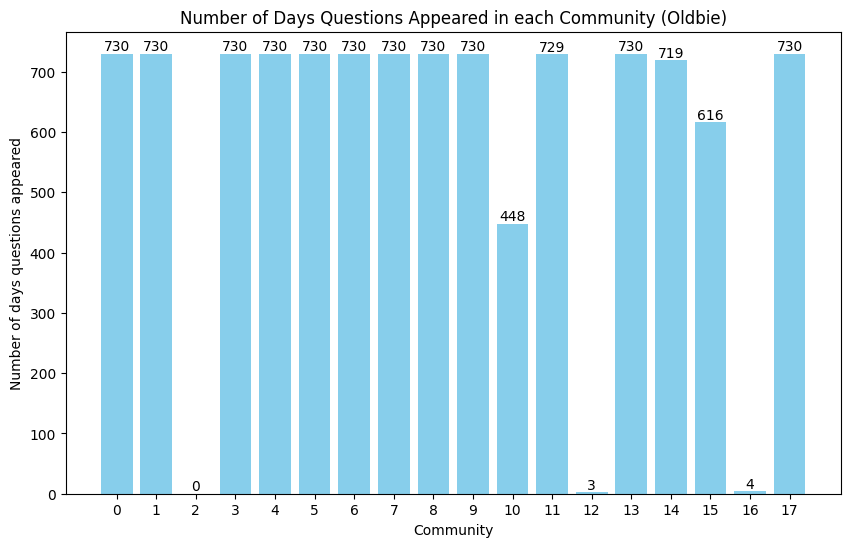

In [36]:
# 총 730개 중 몇몇 클러스터에서 등장한 횟수가 10번 이하인 것은 제외.
vis_count = df_final_old.groupby('community')['count_q'].apply(lambda x: (x != 0).sum()).reset_index()

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bars = plt.bar(vis_count['community'].astype(str), vis_count['count_q'], color='skyblue')

# Adding titles and labels
plt.title('Number of Days Questions Appeared in each Community (Oldbie)')
plt.xlabel('Community')
plt.ylabel('Number of days questions appeared')

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval),ha = 'center', va='bottom')  # va: vertical alignment

# Display the plot
plt.show()

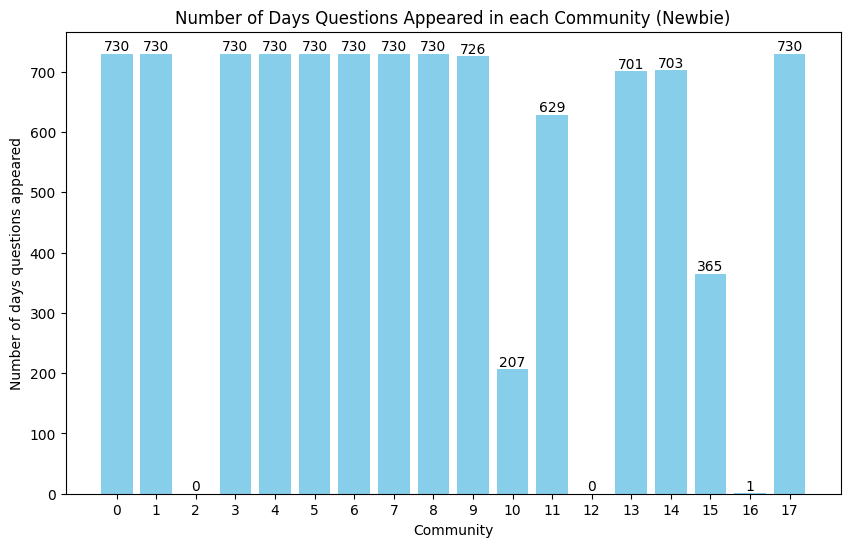

In [37]:
# 총 730개 중 몇몇 클러스터에서 등장한 횟수가 10번 이하인 것은 제외.
vis_count = df_final_new.groupby('community')['count_q'].apply(lambda x: (x != 0).sum()).reset_index()

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
bars = plt.bar(vis_count['community'].astype(str), vis_count['count_q'], color='skyblue')

# Adding titles and labels
plt.title('Number of Days Questions Appeared in each Community (Newbie)')
plt.xlabel('Community')
plt.ylabel('Number of days questions appeared')

# Adding labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval),ha = 'center', va='bottom')  # va: vertical alignment

# Display the plot
plt.show()

In [39]:
def outlierControl(data):
    # Erase tags with the clusters (2,12,16)
    df = data[(data['community'] != 2)&(data['community'] != 12)&(data['community'] != 16)]
    # erase -inf values
    df['ln_entropy'] = np.log(df['entropy'])
    df.replace(-np.inf, np.nan, inplace=True)
    df = df.dropna()
    # Final Setup
    df['year_month_day'] = pd.to_datetime(df['year_month_day'])
    df['year_month'] = df['year_month_day'].dt.to_period('M') # monthly
    df['year_month'] = df['year_month'].astype(str)
    df['year_month_day'] = df['year_month_day'].astype(str)
    df['count_q'] = df['count_q'].astype(int)
    df['count_a'] = df['count_a'].astype(int)
    return df

In [40]:
df_final_old = outlierControl(df_final_old)
df_final_new = outlierControl(df_final_new)

/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_1222750/341675474.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ln_entropy'] = np.log(df['entropy'])
/tmp/ipykernel_1222750/341675474.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace(-np.inf, np.nan, inplace=True)
/home/cglee/anaconda3/envs/ahnlab/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by z

In [41]:
df_final_old

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month
0,2021-09-01,0,0,9,0,0.525040,7.320204,727,814,6.588926,6.701960,1.990638,2021-09
1,2021-09-01,0,0,9,1,0.412791,7.269554,269,182,5.594711,5.204007,1.983695,2021-09
3,2021-09-01,0,0,9,3,0.490224,7.115008,243,215,5.493061,5.370638,1.962206,2021-09
4,2021-09-01,0,0,9,4,0.439161,7.490236,230,268,5.438079,5.590987,2.013600,2021-09
5,2021-09-01,0,0,9,5,0.461350,6.844602,236,213,5.463832,5.361292,1.923460,2021-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13131,2023-08-31,1,1,8,9,0.541652,4.381050,18,13,2.890372,2.564949,1.477288,2023-08
13132,2023-08-31,1,1,8,10,0.373225,2.947703,3,1,1.098612,0.000000,1.081026,2023-08
13133,2023-08-31,1,1,8,11,0.476285,3.708966,11,10,2.397895,2.302585,1.310753,2023-08
13135,2023-08-31,1,1,8,13,0.421145,5.317946,21,11,3.044522,2.397895,1.671087,2023-08


In [42]:
df_final_new

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month
0,2021-09-01,0,0,9,0,0.525040,6.588325,463,200,6.137727,5.298317,1.885299,2021-09
1,2021-09-01,0,0,9,1,0.412791,6.426070,129,42,4.859812,3.737670,1.860363,2021-09
3,2021-09-01,0,0,9,3,0.490224,6.357754,144,32,4.969813,3.465736,1.849675,2021-09
4,2021-09-01,0,0,9,4,0.439161,6.637747,126,37,4.836282,3.610918,1.892773,2021-09
5,2021-09-01,0,0,9,5,0.461350,6.374922,138,45,4.927254,3.806662,1.852372,2021-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13133,2023-08-31,1,1,8,11,0.476285,3.286896,7,2,1.945910,0.693147,1.189944,2023-08
13135,2023-08-31,1,1,8,13,0.421145,3.794653,8,7,2.079442,1.945910,1.333593,2023-08
13136,2023-08-31,1,1,8,14,0.403302,3.128085,6,1,1.791759,0.000000,1.140421,2023-08
13137,2023-08-31,1,1,8,15,0.307775,3.000000,4,2,1.386294,0.693147,1.098612,2023-08


### 5-2 Save Data

In [44]:
df_final_old.to_csv('df_final_old.csv', index=False)
df_final_new.to_csv('df_final_new.csv', index=False)

## 6 Add Control Variable (Num users in a community)

In [52]:
with open(file = 'df_old_cluster.pickle', mode = 'rb') as file:
    df_old_cluster = pickle.load(file)
with open(file = 'df_new_cluster.pickle', mode = 'rb') as file:
    df_new_cluster = pickle.load(file)

In [54]:
# Import Modules
import pandas as pd
import numpy as np
import sqlite3
import pandas as pd
from nltk import FreqDist
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT id, owner_user_id
FROM questions
WHERE creation_date > '2021-09-01'
AND creation_date < '2023-09-01';
'''
df_users = pd.read_sql_query(query, conn)
conn.close()

In [62]:
def addControl(data):
    control = pd.merge(data, df_users, on = 'id', how = 'left')
    control = control.dropna()
    control['owner_user_id'] = control['owner_user_id'].astype(int).astype('str')
    control['year_month'] = pd.to_datetime(control['creation_date']).dt.to_period('M') # Monthly
    control['year_month'] = control['year_month'].astype(str)
    return control.groupby(['year_month', 'community'])['owner_user_id'].nunique().reset_index()

In [64]:
agg_monthly_old = addControl(df_old_cluster)
agg_monthly_new = addControl(df_new_cluster)
agg_monthly_old

,year_month,community,owner_user_id
0,2021-09,0,13451
1,2021-09,1,5246
2,2021-09,2,1
3,2021-09,3,4814
4,2021-09,4,4602
...,...,...,...
376,2023-08,11,205
377,2023-08,13,393
378,2023-08,14,85
379,2023-08,15,68


In [70]:
# Get og data computed from Entropy.ipynb
df_final_old = pd.read_csv('df_final_old.csv')
df_final_new = pd.read_csv('df_final_new.csv')
df_old = pd.merge(df_final_old, agg_monthly_old, on = ['year_month', 'community'], how = 'left')
df_new = pd.merge(df_final_new, agg_monthly_new, on = ['year_month', 'community'], how = 'left')
df_old = df_old.rename(columns = {'owner_user_id': 'numUser'})
df_new = df_new.rename(columns = {'owner_user_id': 'numUser'})
df_old['ln_numUser'] = np.log(df_old['numUser'])
df_new['ln_numUser'] = np.log(df_new['numUser'])

In [71]:
df_old

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month,numUser,ln_numUser
0,2021-09-01,0,0,9,0,0.525040,7.320204,727,814,6.588926,6.701960,1.990638,2021-09,13451,9.506809
1,2021-09-01,0,0,9,1,0.412791,7.269554,269,182,5.594711,5.204007,1.983695,2021-09,5246,8.565221
2,2021-09-01,0,0,9,3,0.490224,7.115008,243,215,5.493061,5.370638,1.962206,2021-09,4814,8.479284
3,2021-09-01,0,0,9,4,0.439161,7.490236,230,268,5.438079,5.590987,2.013600,2021-09,4602,8.434246
4,2021-09-01,0,0,9,5,0.461350,6.844602,236,213,5.463832,5.361292,1.923460,2021-09,4880,8.492900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10484,2023-08-31,1,1,8,9,0.541652,4.381050,18,13,2.890372,2.564949,1.477288,2023-08,200,5.298317
10485,2023-08-31,1,1,8,10,0.373225,2.947703,3,1,1.098612,0.000000,1.081026,2023-08,45,3.806662
10486,2023-08-31,1,1,8,11,0.476285,3.708966,11,10,2.397895,2.302585,1.310753,2023-08,205,5.323010
10487,2023-08-31,1,1,8,13,0.421145,5.317946,21,11,3.044522,2.397895,1.671087,2023-08,393,5.973810


In [72]:
df_new

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month,numUser,ln_numUser
0,2021-09-01,0,0,9,0,0.525040,6.588325,463,200,6.137727,5.298317,1.885299,2021-09,8865,9.089866
1,2021-09-01,0,0,9,1,0.412791,6.426070,129,42,4.859812,3.737670,1.860363,2021-09,2574,7.853216
2,2021-09-01,0,0,9,3,0.490224,6.357754,144,32,4.969813,3.465736,1.849675,2021-09,2900,7.972466
3,2021-09-01,0,0,9,4,0.439161,6.637747,126,37,4.836282,3.610918,1.892773,2021-09,3118,8.044947
4,2021-09-01,0,0,9,5,0.461350,6.374922,138,45,4.927254,3.806662,1.852372,2021-09,2629,7.874359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9850,2023-08-31,1,1,8,11,0.476285,3.286896,7,2,1.945910,0.693147,1.189944,2023-08,138,4.927254
9851,2023-08-31,1,1,8,13,0.421145,3.794653,8,7,2.079442,1.945910,1.333593,2023-08,237,5.468060
9852,2023-08-31,1,1,8,14,0.403302,3.128085,6,1,1.791759,0.000000,1.140421,2023-08,193,5.262690
9853,2023-08-31,1,1,8,15,0.307775,3.000000,4,2,1.386294,0.693147,1.098612,2023-08,54,3.988984


## 7. Add 3 more Target Variables using numComment.ipynb

In [76]:
# Post Data
import pandas as pd
import numpy as np
import sqlite3
import pickle
import math
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm

# Import Dataset
conn = sqlite3.connect('/data1/StackOverflow/stackexchange-to-sqlite/stack.db')
query = '''
SELECT *
FROM posts
WHERE creation_date > '2021-09-01'
AND creation_date < '2023-09-01';
'''
df = pd.read_sql_query(query, conn)
conn.close()

In [77]:
df_post = df[['id', 'post_type', 'creation_date', 'answers', 'comments', 'parent_id', 'tags', 'body']]
df_post = df_post[(df_post['post_type']=='question') | (df_post['post_type'] == 'answer')]
# For answers data, convert the id to the parent_id.
df_post['id'] = df_post.apply(lambda row: row['parent_id'] if row['post_type'] == 'answer' else row['id'], axis = 1)
df_post

,id,post_type,creation_date,answers,comments,parent_id,tags,body
0,69006229.0,answer,2021-09-01 00:00:18.070,0,1,69006229.0,None,"<p>The short approach, remove python3.9 from y..."
1,68746577.0,answer,2021-09-01 00:00:28.823,0,0,68746577.0,None,"<p>open the terminal, run as administrator.</p..."
2,69006293.0,answer,2021-09-01 00:00:35.537,0,2,69006293.0,None,"<p>Conceptually, <code>Base</code> has no reas..."
3,69006423.0,question,2021-09-01 00:00:35.237,1,0,NaN,"[""node.js"", ""reactjs"", ""express"", ""axios"", ""re...",<p>Using interceptors for the first time to re...
4,69006426.0,question,2021-09-01 00:00:55.583,1,0,NaN,"[""r"", ""shiny""]","<p>The APP below uses <code>navbarPage</code>,..."
...,...,...,...,...,...,...,...,...
5844592,76922631.0,answer,2023-08-31 23:56:47.647,0,0,76922631.0,None,"<p>I had the same error, I fixed it by followi..."
5844593,77019854.0,question,2023-08-31 23:57:28.633,0,2,NaN,"[""angular"", ""typescript"", ""progressive-web-app...",<p>I utilized the guidelines presented in <a h...
5844594,77019829.0,answer,2023-08-31 23:57:36.797,0,0,77019829.0,None,"<p>In your Razor component, you can inject the..."
5844595,77019856.0,question,2023-08-31 23:58:56.693,0,0,NaN,"[""next.js""]","<p>I have the following structure, i am using ..."


### 7-1 Get Pre-computed Cluster info and merge

In [93]:
with open(file = 'df_old_cluster.pickle', mode = 'rb') as file:
    df_old_cluster = pickle.load(file)
with open(file = 'df_new_cluster.pickle', mode = 'rb') as file:
    df_new_cluster = pickle.load(file)
df_post['id'] = df_post['id'].astype(int)
df_merge_old = pd.merge(df_post, df_old_cluster[['id', 'community']], on = 'id', how = 'left')
df_merge_new = pd.merge(df_post, df_new_cluster[['id', 'community']], on = 'id', how = 'left')

In [94]:
def preProcess(data):
    df_filtered = data.dropna(subset = ['community'])
    df_filtered['community'] = df_filtered['community'].astype(int)
    df_filtered = df_filtered[(df_filtered['community'] != 2) & (df_filtered['community'] != 12) & (df_filtered['community'] != 16)]
    #create daily timeseries data
    df_filtered['year_month_day'] = pd.to_datetime(df_filtered['creation_date']).dt.to_period('D') # daily
    df_filtered['year_month_day'] = df_filtered['year_month_day'].astype(str)
    return df_filtered

In [95]:
df_merge_old = preProcess(df_merge_old)
df_merge_new = preProcess(df_merge_new)

/tmp/ipykernel_1222750/1160610124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['community'] = df_filtered['community'].astype(int)


/tmp/ipykernel_1222750/1160610124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['community'] = df_filtered['community'].astype(int)


### 7-2 Compute Total Number of Comments

In [97]:
numComments_old = df_merge_old.groupby(['year_month_day', 'community'])['comments'].sum().reset_index()
numComments_new = df_merge_new.groupby(['year_month_day', 'community'])['comments'].sum().reset_index()
numComments_old

,year_month_day,community,comments
0,2021-09-01,0,2163
1,2021-09-01,1,814
2,2021-09-01,3,676
3,2021-09-01,4,1051
4,2021-09-01,5,588
...,...,...,...
10770,2023-08-31,11,15
10771,2023-08-31,13,40
10772,2023-08-31,14,0
10773,2023-08-31,15,1


In [98]:
# (Old) Make blank matrix with dates and community info.
df_blank = pd.DataFrame({'year_month_day': np.repeat(np.array(df_merge_old['year_month_day'].unique()), 15), # Duplicate each date value (730) by the number of cluster (15)
              'community': np.tile(np.array(numComments_old['community'].unique()), 730)}) # Duplicate cluster info 730 times(number of unique dates)
df_final_old = pd.merge(df_blank, numComments_old, on = ['year_month_day', 'community'], how = 'left')
# 730*15 observation
df_final_old

,year_month_day,community,comments
0,2021-09-01,0,2163.0
1,2021-09-01,1,814.0
2,2021-09-01,3,676.0
3,2021-09-01,4,1051.0
4,2021-09-01,5,588.0
...,...,...,...
10945,2023-08-31,11,15.0
10946,2023-08-31,13,40.0
10947,2023-08-31,14,0.0
10948,2023-08-31,15,1.0


In [99]:
# (New) Make blank matrix with dates and community info.
df_blank = pd.DataFrame({'year_month_day': np.repeat(np.array(df_merge_new['year_month_day'].unique()), 15), # Duplicate each date value (730) by the number of cluster (15)
              'community': np.tile(np.array(numComments_new['community'].unique()), 730)}) # Duplicate cluster info 730 times(number of unique dates)
df_final_new = pd.merge(df_blank, numComments_new, on = ['year_month_day', 'community'], how = 'left')
# 730*15 observation
df_final_new

,year_month_day,community,comments
0,2021-09-01,0,1375.0
1,2021-09-01,1,467.0
2,2021-09-01,3,441.0
3,2021-09-01,4,738.0
4,2021-09-01,5,376.0
...,...,...,...
10945,2023-08-31,11,15.0
10946,2023-08-31,13,9.0
10947,2023-08-31,14,1.0
10948,2023-08-31,15,6.0


In [100]:
# Fill NAs with 0.
df_final_old['comments'] = df_final_old['comments'].fillna(0).astype(int)
df_final_new['comments'] = df_final_new['comments'].fillna(0).astype(int)

### 7-3 Compute Average Number of Comments per Post

In [102]:
ComPerQ_old = df_merge_old.groupby(['year_month_day', 'community'])['comments'].mean().reset_index(name = 'CommentsPerQ')
ComPerQ_new = df_merge_new.groupby(['year_month_day', 'community'])['comments'].mean().reset_index(name = 'CommentsPerQ')
# Merge to the final data.
df_final_old = pd.merge(df_final_old, ComPerQ_old, on = ['year_month_day', 'community'], how = 'left')
df_final_new = pd.merge(df_final_new, ComPerQ_new, on = ['year_month_day', 'community'], how = 'left')
# Fill NAs with 0.
df_final_old['CommentsPerQ'] = df_final_old['CommentsPerQ'].fillna(0)
df_final_new['CommentsPerQ'] = df_final_new['CommentsPerQ'].fillna(0)

In [104]:
df_final_new

,year_month_day,community,comments,CommentsPerQ
0,2021-09-01,0,1375,1.576835
1,2021-09-01,1,467,2.213270
2,2021-09-01,3,441,1.792683
3,2021-09-01,4,738,3.024590
4,2021-09-01,5,376,1.649123
...,...,...,...,...
10945,2023-08-31,11,15,1.666667
10946,2023-08-31,13,9,0.750000
10947,2023-08-31,14,1,0.166667
10948,2023-08-31,15,6,1.000000


### 7-4 Compute Answer per Question

In [106]:
questions_old = df_merge_old[df_merge_old['post_type'] == 'question']
AnsPerQ_old = questions_old.groupby(['year_month_day', 'community'])['answers'].mean().reset_index(name = 'AnsPerQ')
questions_new = df_merge_new[df_merge_new['post_type'] == 'question']
AnsPerQ_new = questions_new.groupby(['year_month_day', 'community'])['answers'].mean().reset_index(name = 'AnsPerQ')
# Merge to the final data.
df_final_old = pd.merge(df_final_old, AnsPerQ_old, on = ['year_month_day', 'community'], how = 'left')
# Fill NAs with 0.
df_final_old['AnsPerQ'] = df_final_old['AnsPerQ'].fillna(0)

# Merge to the final data.
df_final_new = pd.merge(df_final_new, AnsPerQ_new, on = ['year_month_day', 'community'], how = 'left')
# Fill NAs with 0.
df_final_new['AnsPerQ'] = df_final_new['AnsPerQ'].fillna(0)

In [111]:
df_final_new

,year_month_day,community,comments,CommentsPerQ,AnsPerQ
0,2021-09-01,0,1375,1.576835,1.129590
1,2021-09-01,1,467,2.213270,1.023256
2,2021-09-01,3,441,1.792683,1.097222
3,2021-09-01,4,738,3.024590,1.182540
4,2021-09-01,5,376,1.649123,0.971014
...,...,...,...,...,...
10945,2023-08-31,11,15,1.666667,0.285714
10946,2023-08-31,13,9,0.750000,0.500000
10947,2023-08-31,14,1,0.166667,0.000000
10948,2023-08-31,15,6,1.000000,0.750000


In [110]:
df_final_new.isna().sum()

year_month_day    0
community         0
comments          0
CommentsPerQ      0
AnsPerQ           0
dtype: int64

## 8. Final Setup for DDD and Save Data

In [112]:
df_old

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month,numUser,ln_numUser
0,2021-09-01,0,0,9,0,0.525040,7.320204,727,814,6.588926,6.701960,1.990638,2021-09,13451,9.506809
1,2021-09-01,0,0,9,1,0.412791,7.269554,269,182,5.594711,5.204007,1.983695,2021-09,5246,8.565221
2,2021-09-01,0,0,9,3,0.490224,7.115008,243,215,5.493061,5.370638,1.962206,2021-09,4814,8.479284
3,2021-09-01,0,0,9,4,0.439161,7.490236,230,268,5.438079,5.590987,2.013600,2021-09,4602,8.434246
4,2021-09-01,0,0,9,5,0.461350,6.844602,236,213,5.463832,5.361292,1.923460,2021-09,4880,8.492900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10484,2023-08-31,1,1,8,9,0.541652,4.381050,18,13,2.890372,2.564949,1.477288,2023-08,200,5.298317
10485,2023-08-31,1,1,8,10,0.373225,2.947703,3,1,1.098612,0.000000,1.081026,2023-08,45,3.806662
10486,2023-08-31,1,1,8,11,0.476285,3.708966,11,10,2.397895,2.302585,1.310753,2023-08,205,5.323010
10487,2023-08-31,1,1,8,13,0.421145,5.317946,21,11,3.044522,2.397895,1.671087,2023-08,393,5.973810


In [115]:
df_old_vr2 = pd.merge(df_old, df_final_old, on = ['year_month_day', 'community'], how = 'left')
df_new_vr2 = pd.merge(df_new, df_final_new, on = ['year_month_day', 'community'], how = 'left')

In [116]:
df_old_vr2

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month,numUser,ln_numUser,comments,CommentsPerQ,AnsPerQ
0,2021-09-01,0,0,9,0,0.525040,7.320204,727,814,6.588926,6.701960,1.990638,2021-09,13451,9.506809,2163,1.637396,1.181568
1,2021-09-01,0,0,9,1,0.412791,7.269554,269,182,5.594711,5.204007,1.983695,2021-09,5246,8.565221,814,1.975728,1.040892
2,2021-09-01,0,0,9,3,0.490224,7.115008,243,215,5.493061,5.370638,1.962206,2021-09,4814,8.479284,676,1.751295,0.962963
3,2021-09-01,0,0,9,4,0.439161,7.490236,230,268,5.438079,5.590987,2.013600,2021-09,4602,8.434246,1051,2.582310,1.130435
4,2021-09-01,0,0,9,5,0.461350,6.844602,236,213,5.463832,5.361292,1.923460,2021-09,4880,8.492900,588,1.466334,1.326271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10484,2023-08-31,1,1,8,9,0.541652,4.381050,18,13,2.890372,2.564949,1.477288,2023-08,200,5.298317,27,1.000000,0.611111
10485,2023-08-31,1,1,8,10,0.373225,2.947703,3,1,1.098612,0.000000,1.081026,2023-08,45,3.806662,1,0.250000,0.333333
10486,2023-08-31,1,1,8,11,0.476285,3.708966,11,10,2.397895,2.302585,1.310753,2023-08,205,5.323010,15,0.714286,0.909091
10487,2023-08-31,1,1,8,13,0.421145,5.317946,21,11,3.044522,2.397895,1.671087,2023-08,393,5.973810,40,1.142857,0.380952


In [117]:
df_new_vr2

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,year_month,numUser,ln_numUser,comments,CommentsPerQ,AnsPerQ
0,2021-09-01,0,0,9,0,0.525040,6.588325,463,200,6.137727,5.298317,1.885299,2021-09,8865,9.089866,1375,1.576835,1.129590
1,2021-09-01,0,0,9,1,0.412791,6.426070,129,42,4.859812,3.737670,1.860363,2021-09,2574,7.853216,467,2.213270,1.023256
2,2021-09-01,0,0,9,3,0.490224,6.357754,144,32,4.969813,3.465736,1.849675,2021-09,2900,7.972466,441,1.792683,1.097222
3,2021-09-01,0,0,9,4,0.439161,6.637747,126,37,4.836282,3.610918,1.892773,2021-09,3118,8.044947,738,3.024590,1.182540
4,2021-09-01,0,0,9,5,0.461350,6.374922,138,45,4.927254,3.806662,1.852372,2021-09,2629,7.874359,376,1.649123,0.971014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9850,2023-08-31,1,1,8,11,0.476285,3.286896,7,2,1.945910,0.693147,1.189944,2023-08,138,4.927254,15,1.666667,0.285714
9851,2023-08-31,1,1,8,13,0.421145,3.794653,8,7,2.079442,1.945910,1.333593,2023-08,237,5.468060,9,0.750000,0.500000
9852,2023-08-31,1,1,8,14,0.403302,3.128085,6,1,1.791759,0.000000,1.140421,2023-08,193,5.262690,1,0.166667,0.000000
9853,2023-08-31,1,1,8,15,0.307775,3.000000,4,2,1.386294,0.693147,1.098612,2023-08,54,3.988984,6,1.000000,0.750000


In [119]:
# There are 55 0 values encountered in comments variable.
print("(Oldbie) There are %d zeros encountered in Comments variable" %len(df_old_vr2[df_old_vr2['comments'] == 0]))
print("(Oldbie) There are %d zeros encountered in AnsPerQ variable" %len(df_old_vr2[df_old_vr2['AnsPerQ'] == 0]))
print("(Oldbie) There are %d zeros encountered in CommentsPerQ variable" %len(df_old_vr2[df_old_vr2['CommentsPerQ'] == 0]))

(Oldbie) There are 148 zeros encountered in Comments variable
(Oldbie) There are 90 zeros encountered in AnsPerQ variable
(Oldbie) There are 148 zeros encountered in CommentsPerQ variable


In [120]:
# There are 55 0 values encountered in comments variable.
print("(Newbie) There are %d zeros encountered in Comments variable" %len(df_new_vr2[df_new_vr2['comments'] == 0]))
print("(Newbie) There are %d zeros encountered in AnsPerQ variable" %len(df_new_vr2[df_new_vr2['AnsPerQ'] == 0]))
print("(Newbie) There are %d zeros encountered in CommentsPerQ variable" %len(df_new_vr2[df_new_vr2['CommentsPerQ'] == 0]))

(Newbie) There are 68 zeros encountered in Comments variable
(Newbie) There are 39 zeros encountered in AnsPerQ variable
(Newbie) There are 68 zeros encountered in CommentsPerQ variable


In [121]:
# (OB) Outlier Control to compute log.
# Remove rows with 0 value (10,489->10,269)

df_old_vr2 = df_old_vr2[(df_old_vr2['comments'] != 0)&(df_old_vr2['AnsPerQ'] != 0)&(df_old_vr2['CommentsPerQ'] != 0)]
df_old_vr2['ln_comments'] = np.log(df_old_vr2['comments'])
df_old_vr2['ln_AnsPerQ'] = np.log(df_old_vr2['AnsPerQ'])
df_old_vr2['ln_CommentsPerQ'] = np.log(df_old_vr2['CommentsPerQ'])
df_old_vr2

/tmp/ipykernel_1222750/3391056336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old_vr2['ln_comments'] = np.log(df_old_vr2['comments'])
/tmp/ipykernel_1222750/3391056336.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_old_vr2['ln_AnsPerQ'] = np.log(df_old_vr2['AnsPerQ'])
/tmp/ipykernel_1222750/3391056336.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,...,ln_entropy,year_month,numUser,ln_numUser,comments,CommentsPerQ,AnsPerQ,ln_comments,ln_AnsPerQ,ln_CommentsPerQ
0,2021-09-01,0,0,9,0,0.525040,7.320204,727,814,6.588926,...,1.990638,2021-09,13451,9.506809,2163,1.637396,1.181568,7.679251,0.166842,0.493107
1,2021-09-01,0,0,9,1,0.412791,7.269554,269,182,5.594711,...,1.983695,2021-09,5246,8.565221,814,1.975728,1.040892,6.701960,0.040078,0.680937
2,2021-09-01,0,0,9,3,0.490224,7.115008,243,215,5.493061,...,1.962206,2021-09,4814,8.479284,676,1.751295,0.962963,6.516193,-0.037740,0.560356
3,2021-09-01,0,0,9,4,0.439161,7.490236,230,268,5.438079,...,2.013600,2021-09,4602,8.434246,1051,2.582310,1.130435,6.957497,0.122602,0.948684
4,2021-09-01,0,0,9,5,0.461350,6.844602,236,213,5.463832,...,1.923460,2021-09,4880,8.492900,588,1.466334,1.326271,6.376727,0.282371,0.382766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10484,2023-08-31,1,1,8,9,0.541652,4.381050,18,13,2.890372,...,1.477288,2023-08,200,5.298317,27,1.000000,0.611111,3.295837,-0.492476,0.000000
10485,2023-08-31,1,1,8,10,0.373225,2.947703,3,1,1.098612,...,1.081026,2023-08,45,3.806662,1,0.250000,0.333333,0.000000,-1.098612,-1.386294
10486,2023-08-31,1,1,8,11,0.476285,3.708966,11,10,2.397895,...,1.310753,2023-08,205,5.323010,15,0.714286,0.909091,2.708050,-0.095310,-0.336472
10487,2023-08-31,1,1,8,13,0.421145,5.317946,21,11,3.044522,...,1.671087,2023-08,393,5.973810,40,1.142857,0.380952,3.688879,-0.965081,0.133531


In [122]:
# (OB) Outlier Control to compute log.
# Remove rows with 0 value (9,855->9,751)

df_new_vr2 = df_new_vr2[(df_new_vr2['comments'] != 0)&(df_new_vr2['AnsPerQ'] != 0)&(df_new_vr2['CommentsPerQ'] != 0)]
df_new_vr2['ln_comments'] = np.log(df_new_vr2['comments'])
df_new_vr2['ln_AnsPerQ'] = np.log(df_new_vr2['AnsPerQ'])
df_new_vr2['ln_CommentsPerQ'] = np.log(df_new_vr2['CommentsPerQ'])
df_new_vr2

/tmp/ipykernel_1222750/4226629410.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_vr2['ln_comments'] = np.log(df_new_vr2['comments'])
/tmp/ipykernel_1222750/4226629410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_vr2['ln_AnsPerQ'] = np.log(df_new_vr2['AnsPerQ'])
/tmp/ipykernel_1222750/4226629410.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

,year_month_day,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,...,ln_entropy,year_month,numUser,ln_numUser,comments,CommentsPerQ,AnsPerQ,ln_comments,ln_AnsPerQ,ln_CommentsPerQ
0,2021-09-01,0,0,9,0,0.525040,6.588325,463,200,6.137727,...,1.885299,2021-09,8865,9.089866,1375,1.576835,1.129590,7.226209,0.121854,0.455420
1,2021-09-01,0,0,9,1,0.412791,6.426070,129,42,4.859812,...,1.860363,2021-09,2574,7.853216,467,2.213270,1.023256,6.146329,0.022990,0.794471
2,2021-09-01,0,0,9,3,0.490224,6.357754,144,32,4.969813,...,1.849675,2021-09,2900,7.972466,441,1.792683,1.097222,6.089045,0.092782,0.583713
3,2021-09-01,0,0,9,4,0.439161,6.637747,126,37,4.836282,...,1.892773,2021-09,3118,8.044947,738,3.024590,1.182540,6.603944,0.167664,1.106776
4,2021-09-01,0,0,9,5,0.461350,6.374922,138,45,4.927254,...,1.852372,2021-09,2629,7.874359,376,1.649123,0.971014,5.929589,-0.029414,0.500244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9849,2023-08-31,1,1,8,9,0.541652,3.980927,13,3,2.564949,...,1.381515,2023-08,310,5.736572,27,1.350000,0.615385,3.295837,-0.485508,0.300105
9850,2023-08-31,1,1,8,11,0.476285,3.286896,7,2,1.945910,...,1.189944,2023-08,138,4.927254,15,1.666667,0.285714,2.708050,-1.252763,0.510826
9851,2023-08-31,1,1,8,13,0.421145,3.794653,8,7,2.079442,...,1.333593,2023-08,237,5.468060,9,0.750000,0.500000,2.197225,-0.693147,-0.287682
9853,2023-08-31,1,1,8,15,0.307775,3.000000,4,2,1.386294,...,1.098612,2023-08,54,3.988984,6,1.000000,0.750000,1.791759,-0.287682,0.000000


In [125]:
df_old_vr2.describe()

,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,numUser,ln_numUser,comments,CommentsPerQ,AnsPerQ,ln_comments,ln_AnsPerQ,ln_CommentsPerQ
count,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000,10269.000000
mean,0.492258,0.751193,6.536372,7.955400,0.430463,5.557096,133.125426,179.913916,3.966529,4.216040,1.646620,3253.877788,7.225020,375.810303,1.370780,0.923564,4.852938,-0.113527,0.229595
std,0.499964,0.432343,3.457934,5.015535,0.070040,1.766913,146.670660,217.082925,1.648836,1.674317,0.404703,3240.018615,1.625338,419.970868,0.516000,0.244182,1.877089,0.266863,0.463176
min,0.000000,0.000000,1.000000,0.000000,0.304784,0.811278,1.000000,1.000000,0.000000,0.000000,-0.209144,23.000000,3.135494,1.000000,0.055556,0.090909,0.000000,-2.397895,-2.890372
25%,0.000000,1.000000,4.000000,4.000000,0.403302,3.979380,13.000000,17.000000,2.564949,2.833213,1.381126,353.000000,5.866468,30.000000,1.099426,0.769231,3.401197,-0.262364,0.094789
50%,0.000000,1.000000,7.000000,8.000000,0.421145,6.391768,95.000000,117.000000,4.553877,4.762174,1.855011,3213.000000,8.074960,245.000000,1.363224,0.933333,5.501258,-0.068993,0.309852
75%,1.000000,1.000000,10.000000,13.000000,0.483382,7.056740,200.000000,256.000000,5.298317,5.545177,1.953983,4527.000000,8.417815,601.000000,1.632860,1.053435,6.398595,0.052056,0.490333
max,1.000000,1.000000,12.000000,17.000000,0.541652,7.851984,739.000000,1071.000000,6.605298,6.976348,2.060766,13451.000000,9.506809,2279.000000,9.000000,4.000000,7.731492,1.386294,2.197225


In [123]:
df_new_vr2.describe()

,T_d,P_t,month,community,techiness,entropy,count_q,count_a,ln_q,ln_a,ln_entropy,numUser,ln_numUser,comments,CommentsPerQ,AnsPerQ,ln_comments,ln_AnsPerQ,ln_CommentsPerQ
count,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000,9751.000000
mean,0.501897,0.753154,6.518101,7.714388,0.434100,5.420097,134.482002,68.090042,3.997278,3.235677,1.631650,3278.077633,7.240989,376.902369,1.383539,0.899516,4.876148,-0.147854,0.238058
std,0.500022,0.431199,3.454474,5.005695,0.068487,1.623394,163.531327,89.602552,1.561899,1.615338,0.369999,3716.229764,1.545750,451.957649,0.508042,0.251894,1.798162,0.301602,0.464077
min,0.000000,0.000000,1.000000,0.000000,0.304784,0.721928,1.000000,1.000000,0.000000,0.000000,-0.325830,19.000000,2.944439,1.000000,0.047619,0.111111,0.000000,-2.197225,-3.044522
25%,0.000000,1.000000,4.000000,4.000000,0.403302,3.932894,13.000000,7.000000,2.564949,1.945910,1.369376,286.000000,5.655992,29.000000,1.090909,0.733333,3.367296,-0.310155,0.087011
50%,1.000000,1.000000,7.000000,7.000000,0.439161,6.084521,82.000000,37.000000,4.406719,3.610918,1.805748,2730.000000,7.912057,222.000000,1.382653,0.903226,5.402677,-0.101783,0.324004
75%,1.000000,1.000000,10.000000,11.000000,0.483382,6.764799,164.000000,79.000000,5.099866,4.369448,1.911732,3813.500000,8.246285,528.000000,1.666667,1.063629,6.269096,0.061687,0.510826
max,1.000000,1.000000,12.000000,17.000000,0.541652,7.878619,880.000000,442.000000,6.779922,6.091310,2.064153,16990.000000,9.740380,2280.000000,5.750000,4.000000,7.731931,1.386294,1.749200


In [126]:
# Save Data
df_old_vr2 = df_old_vr2.rename(columns = {'CommentsPerQ':'CommentsPerP',
                                'ln_CommentsPerQ': 'ln_CommentsPerP'})
df_new_vr2 = df_new_vr2.rename(columns = {'CommentsPerQ':'CommentsPerP',
                                'ln_CommentsPerQ': 'ln_CommentsPerP'})

In [129]:
df_old_vr2.columns

Index(['year_month_day', 'T_d', 'P_t', 'month', 'community', 'techiness',
       'entropy', 'count_q', 'count_a', 'ln_q', 'ln_a', 'ln_entropy',
       'year_month', 'numUser', 'ln_numUser', 'comments', 'CommentsPerP',
       'AnsPerQ', 'ln_comments', 'ln_AnsPerQ', 'ln_CommentsPerP'],
      dtype='object')

In [130]:
df_old_vr2.to_csv('df_final_old_vr2.csv', index = False)
df_new_vr2.to_csv('df_final_new_vr2.csv', index = False)